# <font color = 'indianred'>**Various Experiements NER checkpoints** </font>



## Set Up Environment

In [ ]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate seqeval -U -qq
    base_folder = Path("/content/drive/MyDrive/")
# else:
#     base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorForTokenClassification, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel, Sequence
import evaluate


import wandb
import torch
import gc
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import textwrap

data_folder = base_folder/'datasets/'
model_folder = base_folder/'models/ner'
model_folder.mkdir(exist_ok=True,parents=True)
data_folder.mkdir(exist_ok=True,parents=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**---------DO NOT CHANGE ANY OF THE FUNCTIONS------------**

## Function to Load Dataset

In [ ]:
def load_custom_dataset(dataset_name,select_column_name, text_column_name, label_column_name):
    from datasets import load_dataset
    dataset = load_dataset(dataset_name)
    dataset = dataset.select_columns(select_column_name)
    dataset = dataset.rename_columns({text_column_name: 'text', label_column_name : 'labels'})

    # selected_columns = {
    # 'text': dataset['train'][text_column_name],
    # 'label': dataset['train'][label_columns_name],
    # }

    # # Create a new dataset with the selected columns
    # dataset_selected_columns = Dataset.from_dict(selected_columns)
    # dataset_selected_columns.set_format(type='pandas')
    # df = dataset_selected_columns[:]
    # df['text'] = df['text'].fillna('')
    # dataset_selected_columns.reset_format()

    # if class_names:
    #     dataset_selected_columns = dataset_selected_columns.cast_column('label', ClassLabel(names = class_names))

    return dataset

## Function to Create smaller subset

In [ ]:
def get_small_balanced_subset(dataset, train_size, val_size, test_size):
    train_split_small = dataset['train'].shuffle(seed=42).select(range(train_size))
    val_split_small = dataset['validation'].shuffle(seed=42).select(range(val_size))
    test_split_small = dataset['test'].shuffle(seed=42).select(range(test_size))

    # combine train, val splits into one dataset
    train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

    # create test dataset from test split
    test_subset= DatasetDict({'test': test_split_small})

    return train_val_subset, test_subset


## Function for Tokenization

In [ ]:
def align_targets(labels, word_ids):

    begin2inside = {1:2, 3:4, 5:6, 7:8}

    aligned_labels = []
    last_id = None

    for word_id in word_ids:
      if word_id is None:
        label = -100
      elif word_id != last_id:
        label = labels[word_id]
      else:
        label = labels[word_id]
        if label in begin2inside:
          label = begin2inside[label]

      aligned_labels.append(label)
      last_id = word_id
    return aligned_labels

In [ ]:
def get_tokenized_dataset(checkpoint, dataset):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    def tokenize_fn(batch):
    # CODE HERE
        tokenized_inputs = tokenizer(batch['text'], truncation=True, is_split_into_words=True)

        # Extract the original labels/tags from the batch.
        labels_batch = batch['labels']

        # This list will store the labels aligned with the tokenized input.
        aligned_labels_batch = []

        # Iterate over each example in the batch.
        for i, labels in enumerate(labels_batch):
            # Obtain the word IDs for the tokenized example. This helps in aligning the original labels with the tokens.
            word_ids = tokenized_inputs.word_ids(i)

            # Align the original labels with the tokenized example and append to the aligned_labels_batch list.
            aligned_labels_batch.append(align_targets(labels, word_ids))

        # The HuggingFace trainer expects the labels for token classification tasks to be under the key 'labels'.
        # Store the aligned labels in the 'labels' key of the tokenized_inputs dictionary.
        tokenized_inputs['labels'] = aligned_labels_batch

        return tokenized_inputs

    tokenized_dataset = dataset.map(tokenize_fn, batched=True)
    return tokenized_dataset


## Function to Create Datasets

In [ ]:
def setup_dataset():

    # Constants for loading and splitting
    dataset_name = 'conll2003'
    label_column_name ='ner_tags'
    text_column_name ='tokens'

    # 1. Load Dataset
    dataset = load_custom_dataset(dataset_name ,[text_column_name,label_column_name], text_column_name,label_column_name )

    # 2. Create smaller dataset
    train_val_subset, test_subset = get_small_balanced_subset(_,14041,3250,3453)

    return train_val_subset, test_subset

## Function to Initialize Model

In [ ]:
def initialize_model(checkpoint, class_names):
    config = AutoConfig.from_pretrained(checkpoint)
    id2label = {}
    for id_, label_ in enumerate(class_names):
        id2label[str(id_)] = label_

    label2id = {}
    for id_, label_ in enumerate(class_names):
        label2id[label_] = id_

    config.id2label = id2label
    config.label2id = label2id

    model = AutoModelForTokenClassification.from_pretrained(checkpoint, config=config)
    return model

## Function to Compute Metrics

In [ ]:
seqeval_metric = evaluate.load('seqeval')
def compute_metrics(logits_and_labels):
    # CODE HERE

    logits, true_labels = logits_and_labels
    predicted_indices = np.argmax(logits, axis = -1)
    string_true_labels = [[class_names[label_id] for label_id in sequence if label_id != -100] for sequence in true_labels]

    string_predictions = [
        [class_names[pred_id] for pred_id, true_label_id in zip(pred_sequence, true_sequence) if true_label_id != -100]
        for pred_sequence, true_sequence in zip(predicted_indices, true_labels)
    ]

    metric_results = seqeval_metric.compute(predictions = string_predictions, references =string_true_labels )

    return {
    'precision': metric_results['overall_precision'],
    'recall': metric_results['overall_recall'],
    'f1': metric_results['overall_f1'],
    'accuracy': metric_results['overall_accuracy']
    }


## Function to set Trainer

In [ ]:
def get_trainer(model, training_args, train_dataset, eval_dataset, compute_metrics, tokenizer, data_collator):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator= data_collator
    )
    return trainer

## Function to plot confusion matrix

In [ ]:
def log_and_plot_confusion_matrix(trainer, tokenized_val_dataset, class_names):
    # Perform prediction using the trainer
    valid_output = trainer.predict(tokenized_val_dataset)

    # Extract the predicted labels and true labels
    valid_predictions = np.argmax(valid_output.predictions, axis=2)
    valid_labels = np.array(valid_output.label_ids)
    # 2. Filter out any tokens with label -100 (typically used for padding or special tokens)
    mask = valid_labels != -100
    filtered_predictions = valid_predictions[mask]
    filtered_labels = valid_labels[mask]

    # Log the confusion matrix to wandb
    wandb.log({
        "conf_mat": wandb.plot.confusion_matrix(
            preds=filtered_predictions,        # Model's predicted class labels.
            y_true=filtered_labels,      # Actual labels from the validation set.
            class_names=class_names   # Custom class names for display in the confusion matrix.
        )
    })


    #  Generate the confusion matrix
    cm = confusion_matrix(filtered_labels, filtered_predictions,normalize='true')

    # Plotting the confusion matrix
    plt.figure(figsize=(8, 6))
    ax= sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    # Ensure x-labels are vertical
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Ensure y-labels are horizontal
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Function to free memory

In [ ]:
import gc
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()


## Function to tokenize dataset and, train and eval models

<font color = 'indianred'>**ALLOWED TO CHANGE THE BLOCK IN THE FUNCTION BELOW**

In [ ]:
def tokenize_train_evaluate_log(training_args, checkpoint, base_folder,
                             class_names, train_val_subset, compute_metrics):
    # 1. Free memory
    free_memory()

    # 2. Setup wandb
    wandb.login()
    %env WANDB_PROJECT = nlp_Part-C

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################

    # MAKE SURE THE BASE FOLDER IS SETUP CORRECTLY
    #  YOU CAN CHANGE THIS LINE IF YOU WANT TO SAVE IN A DIFFERENT FOLDER

    model_folder = base_folder/'models/ner'
    model_folder.mkdir(exist_ok=True, parents=True)

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################


    # 3. Get Tokenized Dataset and Data Collator
    train_val_tokenized_dataset = get_tokenized_dataset(checkpoint, train_val_subset)

    # 4. Initialize Model and Tokenizer
    model = initialize_model(checkpoint, class_names)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # 5. Initialize Trainer
    data_collator = DataCollatorForTokenClassification(tokenizer = tokenizer,padding=True,label_pad_token_id=-100,return_tensors='pt')
    trainer = get_trainer(model, training_args, train_val_tokenized_dataset['train'],
                          train_val_tokenized_dataset['val'], compute_metrics, tokenizer, data_collator)

    # 6. Train and Evaluate
    trainer.train()
    trainer.evaluate(train_val_tokenized_dataset['val'])

    # 7. Log Metrics and Plot
    log_and_plot_confusion_matrix(trainer, train_val_tokenized_dataset['val'], class_names)

    best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
    wandb.log({"best_model_checkpoint_step": best_model_checkpoint_step})
    print(f"The best model was saved at step {best_model_checkpoint_step}.")

    wandb.finish()

## Initial Training Arguments

DO NOT CHANGE ANY ARGUMENTS

In [ ]:
# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    # save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=1,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="f1",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)


# Experiments

## Dataset hyperparameters

In [ ]:
class_names = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
train_val_subset, test_subset = setup_dataset()

## Experiment 1 : distilbert-base-uncased with 5000 samples

### Trainer hyperparameters

In [ ]:
checkpoint = "distilbert-base-uncased"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{5000}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

env: WANDB_PROJECT=nlp_course_HW6-Part-C


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.342200,0.866203,0.000000,0.000000,0.000000,0.792906
40,0.738800,0.578053,0.082988,0.011148,0.019656,0.818431
60,0.518800,0.410478,0.544098,0.447046,0.490820,0.872954
80,0.382100,0.316572,0.513444,0.553512,0.532725,0.904742
100,0.305000,0.252465,0.610499,0.648272,0.628819,0.926846
120,0.255300,0.207914,0.612658,0.674470,0.642080,0.939845
140,0.230500,0.180752,0.677303,0.733556,0.704308,0.950266
160,0.225500,0.162595,0.729299,0.765886,0.747145,0.954423
180,0.185700,0.144018,0.755826,0.795429,0.775122,0.960792
200,0.159900,0.131087,0.781366,0.822742,0.801520,0.964002


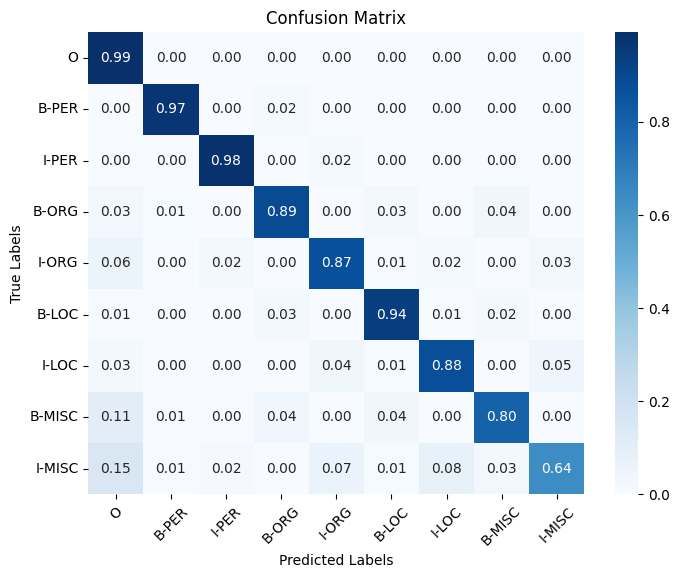

The best model was saved at step 500.


eval/accuracy,▁▂▄▅▆▇▇▇▇▇██████████████████████
eval/f1,▁▁▅▅▆▆▇▇▇▇▇█████████████████████
eval/loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▂▅▅▆▆▇▇▇▇▇█████████████████████
eval/recall,▁▁▅▅▆▆▇▇▇███████████████████████
eval/runtime,▄▂▁▃▂▂▁▁▁▇▃▆█▂▁▂▁▂▃▄▁▁▁▂▁▁▂▂▁▁▂▂
eval/samples_per_second,▃▆█▄▆▅▇██▂▅▂▁▆█▆█▆▄▃██▇▆██▅▆█▇▆▆
eval/steps_per_second,▃▆█▄▆▅▇██▂▅▂▁▆█▆█▆▄▃██▇▆██▅▆█▇▆▆
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

## Experiment 2 : bert-base-cased with 5000 samples

### Trainer hyperparameters

In [ ]:
checkpoint =  "bert-base-cased"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{5000}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)


env: WANDB_PROJECT=nlp_course_HW6-Part-C


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.335000,0.842764,0.000000,0.000000,0.000000,0.763217
40,0.726300,0.488494,0.448109,0.257525,0.327080,0.849284
60,0.428800,0.315906,0.494039,0.577480,0.532511,0.907263
80,0.294500,0.256796,0.562625,0.625975,0.592612,0.922695
100,0.252700,0.200235,0.578140,0.672241,0.621649,0.935693
120,0.212500,0.171565,0.664523,0.748606,0.704063,0.947814
140,0.186700,0.155534,0.732564,0.813824,0.771059,0.955068
160,0.192100,0.146263,0.754736,0.821628,0.786763,0.958183
180,0.166500,0.128498,0.781799,0.842809,0.811159,0.962711
200,0.145300,0.120279,0.783922,0.853400,0.817187,0.964414


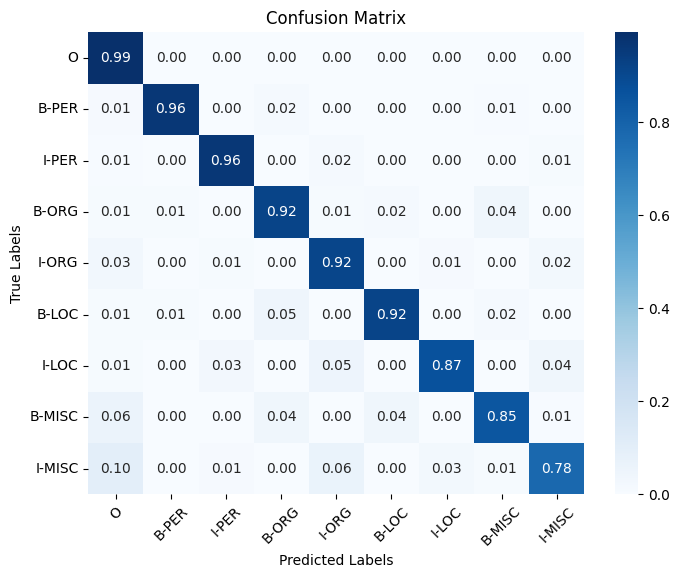

The best model was saved at step 500.


eval/accuracy,▁▄▆▆▇▇▇▇████████████████████████
eval/f1,▁▄▅▆▆▇▇▇▇▇▇█████████████████████
eval/loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▅▅▆▆▆▇▇▇▇▇█████████████████████
eval/recall,▁▃▅▆▆▇▇▇████████████████████████
eval/runtime,▇▂▇▃▂▂▁▆▆▆▁█▁▅▂▂▆▁▇▁▇▁▆▁▁█▃▃▆▂▆▁
eval/samples_per_second,▂▇▂▆▇▇█▃▃▃█▁█▄▇▇▃█▂█▂█▃██▁▆▆▃▇▃█
eval/steps_per_second,▂▇▂▆▇▇█▃▃▃█▁█▄▇▇▃█▂█▂█▃██▁▆▆▃▇▃█
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

## Experiment 3 -  dslim/bert-base-NER with 5000 samples

### Trainer hyperparameters

In [ ]:
checkpoint = "dslim/bert-base-NER"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{5000}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)


env: WANDB_PROJECT=nlp_course_HW6-Part-C


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.212100,0.536352,0.219052,0.290970,0.249940,0.868124
40,0.362800,0.205132,0.621442,0.730212,0.671451,0.946451
60,0.122500,0.103920,0.778717,0.872910,0.823127,0.971570
80,0.046100,0.086019,0.854914,0.916388,0.884584,0.981015
100,0.038300,0.083254,0.880700,0.925864,0.902717,0.981550
120,0.033300,0.079067,0.893048,0.930881,0.911572,0.982962
140,0.025200,0.080354,0.889066,0.933668,0.910821,0.982378
160,0.019700,0.074892,0.904404,0.938685,0.921225,0.983643
180,0.025600,0.072812,0.893730,0.937570,0.915125,0.983935
200,0.019000,0.069305,0.907278,0.938127,0.922445,0.985347


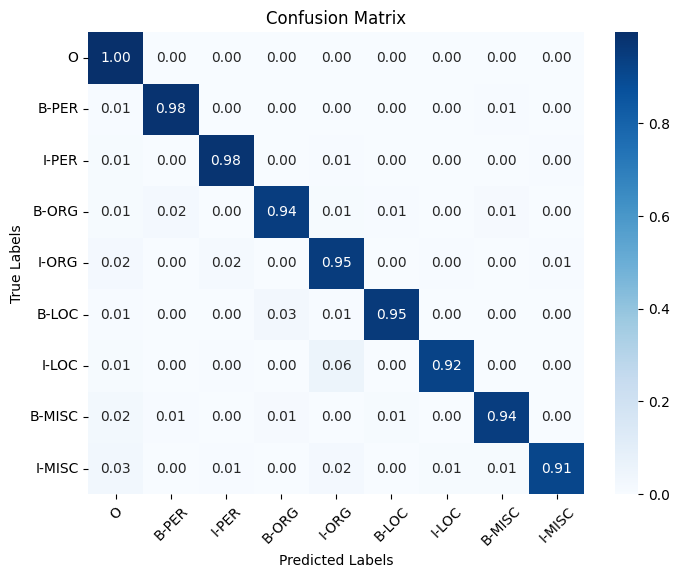

The best model was saved at step 500.


eval/accuracy,▁▆▇█████████████████████████████
eval/f1,▁▅▇▇████████████████████████████
eval/loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▅▇▇████████████████████████████
eval/recall,▁▆▇█████████████████████████████
eval/runtime,▃▂▃▁▃▁▁▂▁▂▁▃▁█▁▃▁▁▁▁▃▁▃▁▃▄▂▄▂▃▁▃
eval/samples_per_second,▅▇▅▇▅██▇█▆█▅█▁█▆██▇█▆█▅█▆▄▆▄▇▅▇▅
eval/steps_per_second,▅▇▅▇▅██▇█▆█▅█▁█▆██▇█▆█▅█▆▄▆▄▇▅▇▅
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

## Experiment 4 -  dslim/bert-base-NER with 14K samples

### Trainer hyperparameters

In [ ]:
checkpoint = "dslim/bert-base-NER"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{14041}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)


env: WANDB_PROJECT=nlp_course_HW6-Part-C


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.108400,0.544578,0.218104,0.284248,0.246822,0.861482
40,0.319300,0.197697,0.617800,0.721979,0.665839,0.945370
60,0.105400,0.099275,0.794802,0.885224,0.837580,0.975305
80,0.042100,0.090777,0.879665,0.920229,0.899490,0.981191
100,0.031400,0.087487,0.888889,0.928980,0.908492,0.981913
120,0.033500,0.082091,0.902570,0.933861,0.917949,0.983517
140,0.020800,0.081221,0.902865,0.938573,0.920373,0.982958
160,0.016900,0.083867,0.896751,0.938405,0.917105,0.982266
180,0.016900,0.087468,0.914810,0.939751,0.927113,0.983841
200,0.020300,0.084262,0.907585,0.940424,0.923713,0.983296


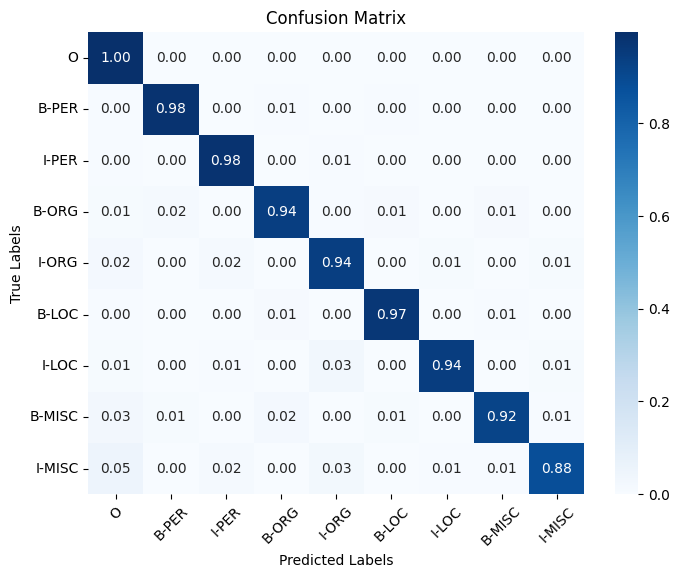

The best model was saved at step 1500.


eval/accuracy,▁▇██████████████████████████████████████
eval/f1,▁▇██████████████████████████████████████
eval/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▇██████████████████████████████████████
eval/recall,▁▇██████████████████████████████████████
eval/runtime,▇▄▄▃▄▃▄▄▃▃▂█▂▄▃▃▃▄▇▂▃▃▃▂▁▂▄▅▄▃▃▃▃▄▃▁▃▃▃▃
eval/samples_per_second,▂▄▅▆▄▆▄▅▆▆▇▁▆▄▅▆▆▅▂▇▆▆▆▇█▇▄▄▄▆▅▆▆▄▅█▆▆▆▆
eval/steps_per_second,▂▄▅▆▄▆▄▅▆▆▇▁▆▄▅▆▆▅▂▇▆▆▆▇█▇▄▄▄▆▅▆▆▄▅█▆▆▆▆
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

# Conclusion
In conclusion, we conducted four experiments to evaluate different models for Named Entity Recognition (NER). We also made an adjustment to the metric used for assessing the best model by setting it to "f1". Each of these experiments was trained on varying numbers of training samples, and the results are as follows:

* Experiment 1: We used the distilbert-base-uncased model with 5000 samples. This model achieved an F1 score of 0.85839 in the evaluation.

* Experiment 2: We employed the bert-base-cased model with 5000 samples. In this case, the model achieved an F1 score of 0.87865.

* Experiment 3: We utilized the dslim/bert-base-NER model with 5000 samples. The third experiment yielded an impressive F1 score of 0.93121.

* Experiment 4: We continued to use the dslim/bert-base-NER model, but this time with a larger training dataset of 14,000 samples. The performance significantly improved, resulting in an F1 score of 0.94136.

Notably, the dslim/bert-base-NER model consistently outperformed the distilbert-base-uncased and bert-base-cased models across all experiments, with the highest F1 score achieved when it was trained on the larger dataset. This suggests that for NER tasks, the dslim/bert-base-NER model may be a better choice, especially when more training data is available. The change in the evaluation metric to "f1" aligns with the observation that F1 score is a suitable metric for NER tasks as it considers both precision and recall.